# Figure 3

In [1]:
import string
import time
import argparse as ap
import sys
import os
import obspy
import obspy.core as oc

from obspy import read
from obspy import UTCDateTime
from obspy.core.event import  Event, Origin, Magnitude, Pick, WaveformStreamID
from obspy import read_events
from obspy import Catalog
from datetime import datetime
from obspy.geodetics import kilometers2degrees
from obspy.geodetics import degrees2kilometers
from obspy.geodetics import FlinnEngdahl
from obspy.geodetics import gps2dist_azimuth
import matplotlib.ticker as ticker

import pandas as pd
import matplotlib as mpl
import pylab as plt
import numpy as np
import math
import linecache
from obspy import read_inventory
import glob




In [2]:
# Funzione per leggere tutti i csv in una directory e concatenarli
def read_csv_from_directory(directory):
    # Prende tutti i file .csv nella directory
    all_files = glob.glob(os.path.join(directory, "*.csv"))
    
    # Legge ogni file e li mette in una lista
    df_list = []
    for file in all_files:
        df = pd.read_csv(file)
        df_list.append(df)
    
    # Unisce tutti i DataFrame in uno solo
    combined_df = pd.concat(df_list, ignore_index=True)
    return combined_df

# Directory 1
dir1 = "/home/jovyan/shared/users/spina/Norcia/NLLoc/SNR"
df_or = read_csv_from_directory(dir1)

# Directory 2
dir2 = "/home/jovyan/shared/users/spina/Norcia/NLLoc/SNR_INSTANCE_005/"  # 👈 sostituisci con il percorso corretto
df_in = read_csv_from_directory(dir2)

print("📊 DataFrame OR:", df_or.shape)
print("📊 DataFrame IN:", df_in.shape)


📊 DataFrame OR: (328223, 14)
📊 DataFrame IN: (328223, 14)


In [3]:
def plot_phase_difference_counts_filtered(df_or, df_in,
                                         p_threshold_or, p_threshold_in,
                                         s_threshold_or, s_threshold_in,
                                         terr_threshold,
                                         dataset1_label, dataset2_label,
                                         output_file=None):

    """
    Confronta i conteggi dei pick P pn e S pn validi per stazione nei due dataset,
    filtrando in base alla probabilità con soglie diverse per OR e IN.
    """

        # Filtri separati per P e S
    df_or_valid_P = df_or[
        (df_or["Pproba"] >= p_threshold_or) &
        (df_or["P_terr"].abs() < terr_threshold)
    ]

    df_or_valid_S = df_or[
        (df_or["Sproba"] >= s_threshold_or) &
        (df_or["S_terr"].abs() < terr_threshold)
    ]

    df_in_valid_P = df_in[
        (df_in["Pproba"] >= p_threshold_in) &
        (df_in["P_terr"].abs() < terr_threshold)
    ]

    df_in_valid_S = df_in[
        (df_in["Sproba"] >= s_threshold_in) &
        (df_in["S_terr"].abs() < terr_threshold)
    ]

    # # Filtra i pick validi secondo la probabilità, separatamente per OR e IN
    # df_or_valid = df_or[(df_or["Pproba"] >= p_threshold_or) | (df_or["Sproba"] >= s_threshold_or)]
    # df_in_valid = df_in[(df_in["Pproba"] >= p_threshold_in) | (df_in["Sproba"] >= s_threshold_in)]
    
    # Conta valori non-null per P e S
    count_or_P = df_or_valid_P[df_or_valid_P["Pproba"] >= p_threshold_or].groupby("Station")["P pn"].count().reset_index(name=f"counts_{dataset1_label}")
    count_in_P = df_in_valid_P[df_in_valid_P["Pproba"] >= p_threshold_in].groupby("Station")["P pn"].count().reset_index(name=f"counts_{dataset2_label}")
    
    count_or_S = df_or_valid_S[df_or_valid_S["Sproba"] >= s_threshold_or].groupby("Station")["S pn"].count().reset_index(name=f"counts_{dataset1_label}")
    count_in_S = df_in_valid_S[df_in_valid_S["Sproba"] >= s_threshold_in].groupby("Station")["S pn"].count().reset_index(name=f"counts_{dataset2_label}")
    
    # Merge
    merged_P = pd.merge(count_or_P, count_in_P, on="Station", how="outer").fillna(0)
    merged_S = pd.merge(count_or_S, count_in_S, on="Station", how="outer").fillna(0)
    
    # Differenze
    merged_P["count_diff"] = merged_P[f"counts_{dataset1_label}"] - merged_P[f"counts_{dataset2_label}"]
    merged_S["count_diff"] = merged_S[f"counts_{dataset1_label}"] - merged_S[f"counts_{dataset2_label}"]
    
    # Setup figura
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    for i, (phase, data, color, label) in enumerate([
        ("P", merged_P, "darkblue", "P picks"),
        ("S", merged_S, "purple", "S picks")
    ]):
        ax = axes[i]
        stations = data["Station"]
        y_pos = np.arange(len(stations))
        
        ax.bar(y_pos, data["count_diff"], align="center", color=color, alpha=0.7, label=label)
        ax.set_xticks(y_pos)
        ax.set_xticklabels(stations, rotation=90, ha="center", fontsize=10)
        ax.set_ylim(data["count_diff"].min()-5, data["count_diff"].max()+5)
        
        ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
        ax.grid(axis="y", linestyle="--", alpha=0.7)
        ax.grid(axis="x", linestyle="--", alpha=0.7)
        
        # Linea verticale per la media
        ax.axhline(data["count_diff"].mean(), color="red", linestyle="dashed", linewidth=1.5, label="Mean diff")
        
        ax.text(0.02, 0.95, f"({chr(97+i)})", transform=ax.transAxes, fontsize=14,
                verticalalignment="top", horizontalalignment="left",
                bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"))
        ax.legend(fontsize=12)
    
    fig.text(0.5, 0.04, "Station", ha="center", fontsize=14)
    fig.text(0.04, 0.5, f"Count difference ({dataset1_label} - {dataset2_label})", 
             va="center", rotation="vertical", fontsize=14)
    
    plt.tight_layout(rect=[0.05, 0.05, 1, 1])
    if output_file:
        plt.savefig(output_file, dpi=300)
    plt.show()


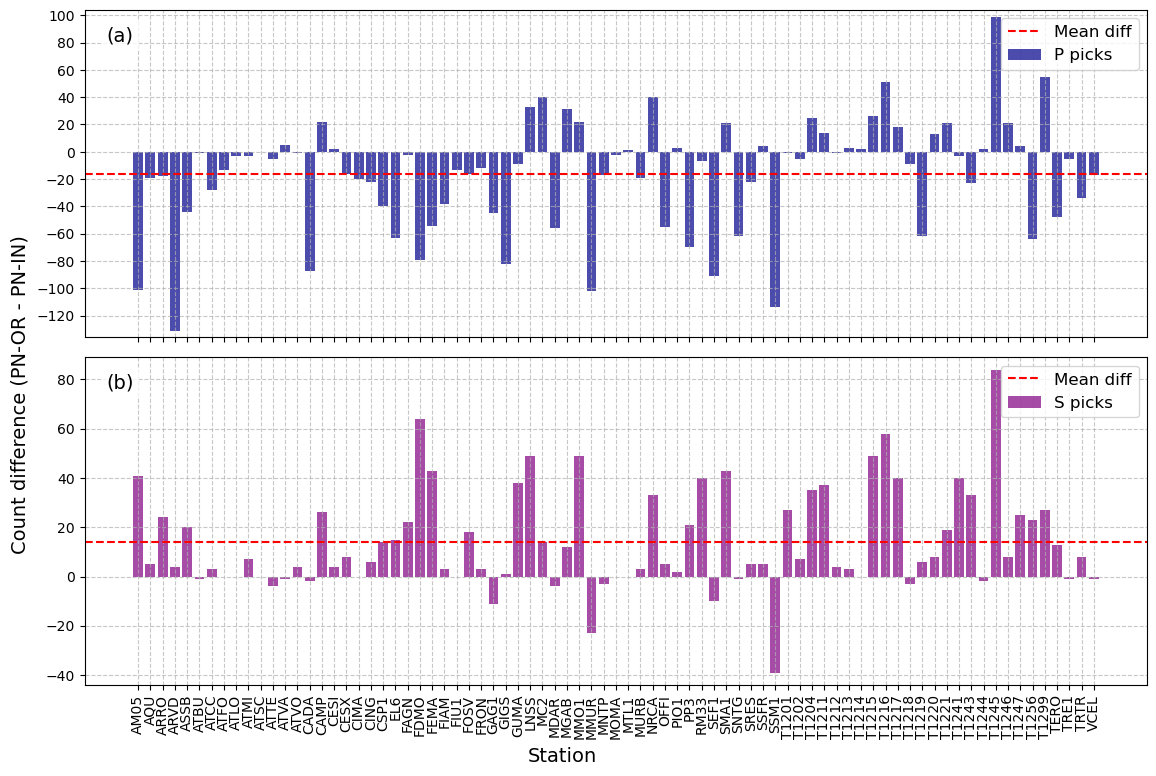

In [4]:
p_threshold_or=0.1
p_threshold_in=0.05
s_threshold_or=0.1
s_threshold_in=0.05
terr_threshold=2
dataset1_label="PN-OR"
dataset2_label="PN-IN"
output_file="missing_picks_OR_IN.png"

plot_phase_difference_counts_filtered(df_or, df_in,
                                         p_threshold_or=p_threshold_or, p_threshold_in=p_threshold_in,
                                         s_threshold_or=s_threshold_or, s_threshold_in=s_threshold_in,
                                      terr_threshold=terr_threshold,
                                         dataset1_label=dataset1_label, dataset2_label=dataset2_label,
                                         output_file=output_file)

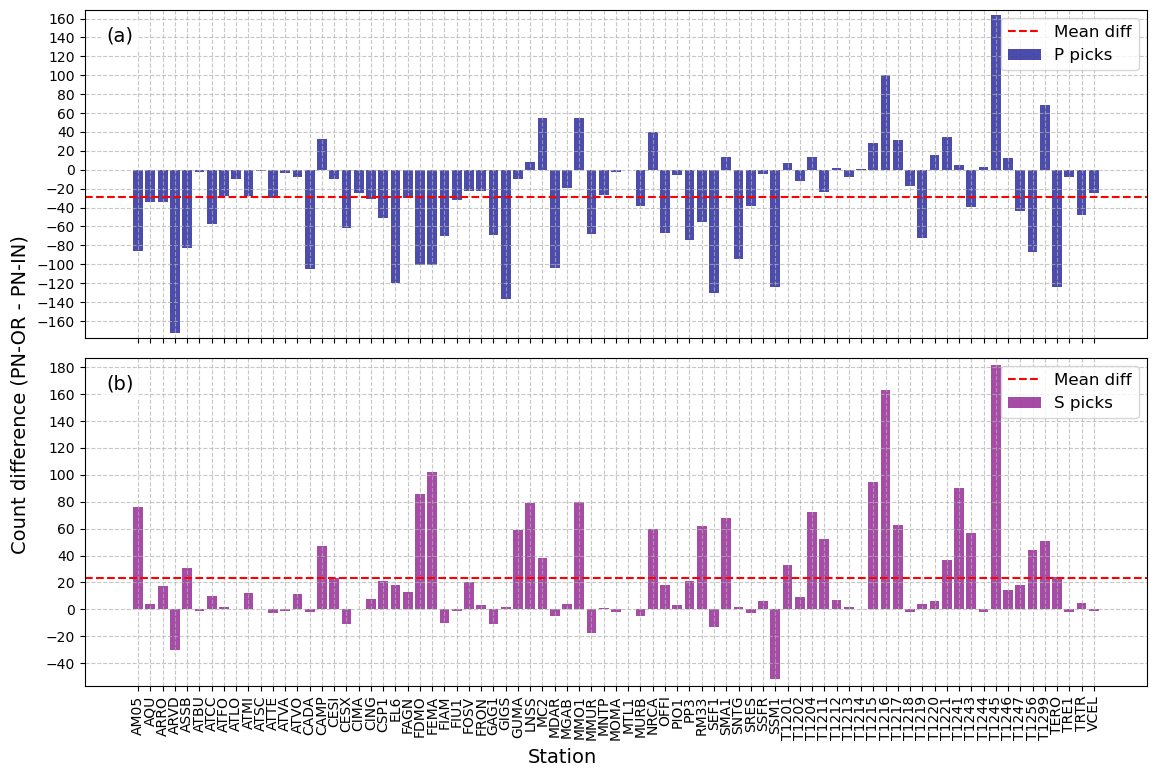

In [6]:
p_threshold_or=0.2
p_threshold_in=0.1
s_threshold_or=0.2
s_threshold_in=0.1
terr_threshold=2
dataset1_label="PN-OR"
dataset2_label="PN-IN"
output_file="missing_picks_OR-02_IN-01.png"

plot_phase_difference_counts_filtered(df_or, df_in,
                                         p_threshold_or=p_threshold_or, p_threshold_in=p_threshold_in,
                                         s_threshold_or=s_threshold_or, s_threshold_in=s_threshold_in,
                                      terr_threshold=terr_threshold,
                                         dataset1_label=dataset1_label, dataset2_label=dataset2_label,
                                         output_file=output_file)

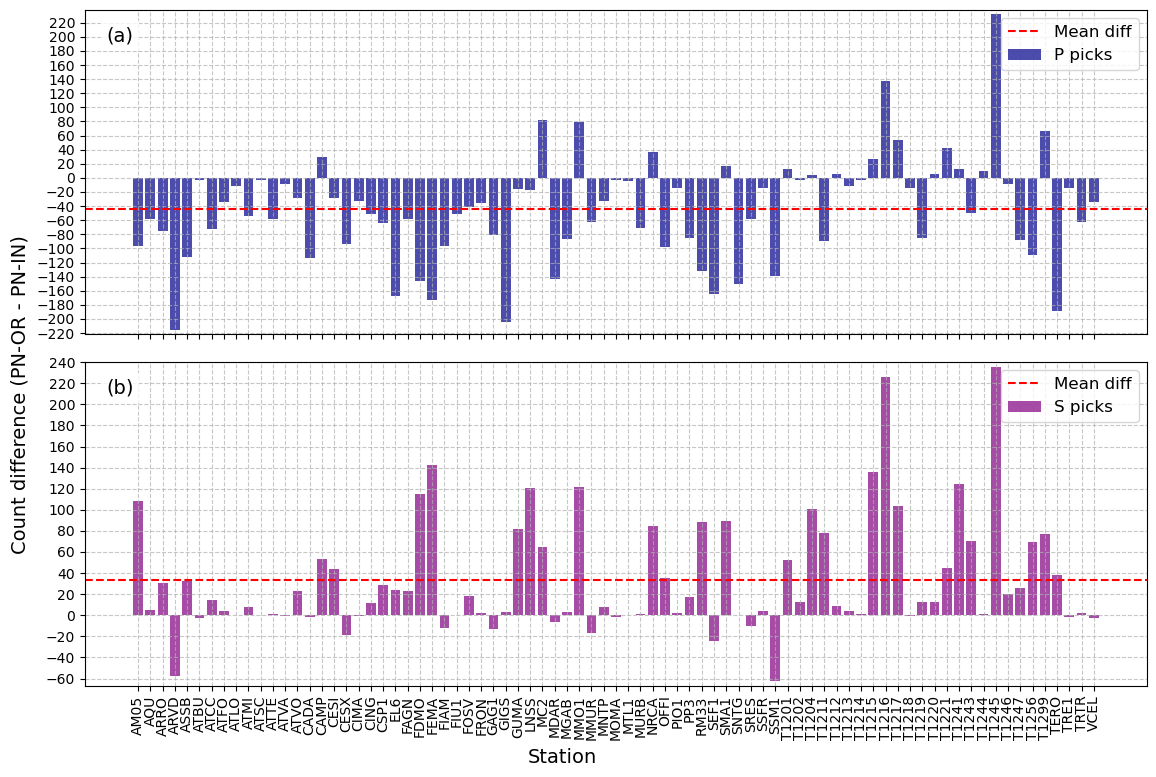

In [7]:
p_threshold_or=0.3
p_threshold_in=0.15
s_threshold_or=0.3
s_threshold_in=0.15
terr_threshold=2
dataset1_label="PN-OR"
dataset2_label="PN-IN"
output_file="missing_picks_OR-03_IN-015.png"

plot_phase_difference_counts_filtered(df_or, df_in,
                                         p_threshold_or=p_threshold_or, p_threshold_in=p_threshold_in,
                                         s_threshold_or=s_threshold_or, s_threshold_in=s_threshold_in,
                                      terr_threshold=terr_threshold,
                                         dataset1_label=dataset1_label, dataset2_label=dataset2_label,
                                         output_file=output_file)